In [2]:
%cd ..

E:\annotation_app


In [3]:
import sys
sys.path.append("backends/pysot")

In [4]:
import os
from argparse import Namespace

In [5]:
import cv2
import torch
import numpy as np
from glob import glob
from pathlib import Path

In [6]:
from image_array import MovieImageArray

In [7]:
from pysot.core.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker

## Modelのコンストラクト 

In [8]:
cfgarg = Namespace(config="backends/pysot/experiments/siammask_r50_l3/config.yaml",
                   snapshot="backends/pysot/experiments/siammask_r50_l3/model.pth",
                  )

In [9]:
cfg.merge_from_file(cfgarg.config)
cfg.CUDA = torch.cuda.is_available() and cfg.CUDA
device = torch.device("cpu")

In [10]:
model = ModelBuilder()

In [11]:
model.load_state_dict(torch.load(cfgarg.snapshot,
    map_location=lambda storage, loc: storage.cpu()))

<All keys matched successfully>

In [12]:
model.eval().to(device)
tracker = build_tracker(model)

## 動画の読み込み 

In [13]:
movie_path = Path("sample_movie/sample_movie_1.mp4")
temp_path = Path("temp")
image_array = MovieImageArray(movie_path, is_temp=False, temp_dir=temp_path)

In [14]:
image_array.read_movie(is_update=False)

## 最初の矩形 

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

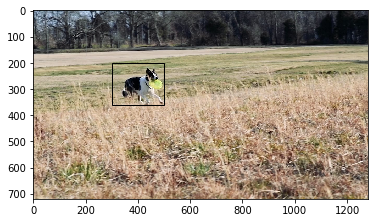

In [16]:
fig, ax = plt.subplots()

x1 = 300
y1 = 200
x2 = 500
y2 = 360

w = x2 - x1
h = y2 - y1

ax.imshow(image_array[0][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)

In [17]:
tracker.init(image_array[0], (x1,y1,w,h))

## 次の矩形を予測 

In [18]:
outputs = tracker.track(image_array[1])

e:\annotation_app\.venv\lib\site-packages\torch\nn\functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [19]:
outputs

{'bbox': [312.26573191191187,
  211.31005075895925,
  199.207546033354,
  156.23182910036763],
 'best_score': 0.99998116,
 'mask': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'polygon': [337.629150390625,
  374.7278747558594,
  325.45465087890625,
  221.32899475097656,
  492.57659912109375,
  208.06533813476562,
  504.7510986328125,
  361.4642333984375]}

In [29]:
polygon_array = np.array(outputs["polygon"]).reshape(-1,2)

In [22]:
x1 = int(outputs["bbox"][0])
y1 = int(outputs["bbox"][1])
x2 = int(outputs["bbox"][0]+outputs["bbox"][2])
y2 = int(outputs["bbox"][1]+outputs["bbox"][3])


w = x2 - x1
h = y2 - y1

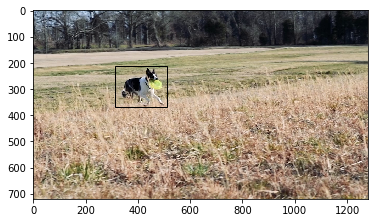

In [23]:
fig, ax = plt.subplots()

ax.imshow(image_array[1][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)

In [25]:
mask_img = (outputs["mask"]*255).astype(np.uint8)

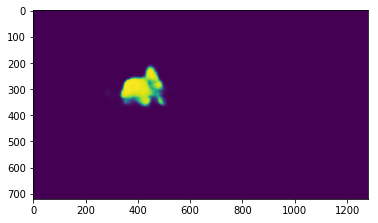

In [26]:
fig, ax = plt.subplots()

ax.imshow(mask_img)

この中から値の大きい領域を取得したい

どうやらポリゴンではうまくいかないらしい

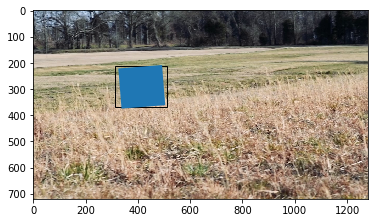

In [30]:
fig, ax = plt.subplots()

ax.imshow(image_array[1][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)
polygon = patches.Polygon(polygon_array, closed=True)
ax.add_patch(polygon)

### 二値化とポリゴンの取得

In [31]:
ret2, img_otsu = cv2.threshold(mask_img, 0, 255, cv2.THRESH_OTSU)

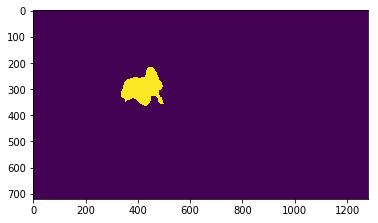

In [32]:
fig, ax = plt.subplots()
ax.imshow(img_otsu)

このx,h,w,hを利用して領域内の平均値が大きいラベルをもとめる

In [58]:
_, contours, _ = cv2.findContours(img_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnt_area = [cv2.contourArea(cnt) for cnt in contours]
if len(contours) != 0 and np.max(cnt_area) > 100:
    contour = contours[np.argmax(cnt_area)]  # use max area polygon
    polygon = contour.reshape(-1, 2)
    pbox = cv2.boundingRect(polygon)  # Min Max Rectangle

    box_in_img = pbox

    epsilon = 0.01*cv2.arcLength(polygon, True)
    approx = cv2.approxPolyDP(polygon, epsilon, True).squeeze()

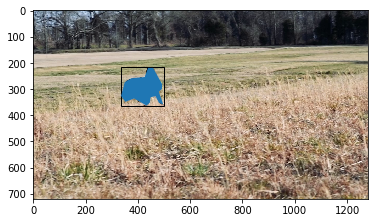

In [59]:
fig, ax = plt.subplots()

x1 = box_in_img[0]
y1 = box_in_img[1]
w = box_in_img[2]
h = box_in_img[3]

ax.imshow(image_array[1][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)
polygon = patches.Polygon(approx, closed=True)
ax.add_patch(polygon)

### 以上を利用したtracker 

In [49]:
class SiamMaskTrackerV2():
    def __init__(self, is_cpu=True, epsilon=0.01):
        is_cpu = not torch.cuda.is_available() and is_cpu
        cfgarg = Namespace(config="backends/pysot/experiments/siammask_r50_l3/config.yaml",
                           snapshot="backends/pysot/experiments/siammask_r50_l3/model.pth",
                          )
        cfg.merge_from_file(cfgarg.config)
        cfg.CUDA = not is_cpu
        device = torch.device("cuda" if not is_cpu else "cpu")
        model = ModelBuilder()
        model.load_state_dict(torch.load(cfgarg.snapshot,
                              map_location=lambda storage, loc: storage.cpu()))
        model.eval().to(device)
        self.tracker = build_tracker(model)
        self.epsilon = epsilon
        
    def set_bbox(self, image, xyxy_dict=None, polygon_list=None):
        if xyxy_dict is None:
            raise Exception("SiameseMaskTracker set_bbox need xyxy_dict")
        x1 = xyxy_dict["x1"]
        y1 = xyxy_dict["y1"]
        x2 = xyxy_dict["x2"]
        y2 = xyxy_dict["y2"]
        w = x2-x1
        h = y2-y1
        
        self.tracker.init(image, (x1,y1,w,h))
        
    def get_bbox(self, image):
        outputs = self.tracker.track(image)
        mask_img = (outputs["mask"]*255).astype(np.uint8)
        _, img_otsu = cv2.threshold(mask_img, 0, 255, cv2.THRESH_OTSU)
        _, contours, _ = cv2.findContours(img_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        out_dict = {}
        
        cnt_area = [cv2.contourArea(cnt) for cnt in contours]
        if len(contours) != 0 and np.max(cnt_area) > 100:
            contour = contours[np.argmax(cnt_area)]  # use max area polygon
            polygon = contour.reshape(-1, 2)
            pbox = cv2.boundingRect(polygon)  # Min Max Rectangle

            out_dict["bbox_dict"] = {"x1":pbox[0],
                                     "y1":pbox[1],
                                     "x2":pbox[0]+pbox[2],
                                     "y2":pbox[1]+pbox[3]
                                    }           
            epsilon = self.epsilon*cv2.arcLength(polygon, True)
            approx = cv2.approxPolyDP(polygon, epsilon, True).squeeze()
            out_dict["polygon"] = [{"x":int(one_point[0]), "y":int(one_point[1])} for one_point in approx]
            
        else:
            out_dict["polygon"] = None
            out_dict["bbox_dict"] = {"x1":None,"y1":None,"x2":None,"y2":None}
        
        return out_dict

In [50]:
box_tracker = SiamMaskTrackerV2()

In [51]:
x1 = 300
y1 = 200
x2 = 500
y2 = 360
xyxy_dict = {"x1":x1, "y1":y1, "x2":x2, "y2":y2}

In [52]:
box_tracker.set_bbox(image_array[0], xyxy_dict)

In [53]:
out_dict = box_tracker.get_bbox(image_array[1])

In [54]:
out_dict

{'bbox_dict': {'x1': 336, 'y1': 216, 'x2': 499, 'y2': 364},
 'polygon': [{'x': 458, 'y': 219},
  {'x': 439, 'y': 219},
  {'x': 426, 'y': 254},
  {'x': 374, 'y': 259},
  {'x': 350, 'y': 274},
  {'x': 336, 'y': 326},
  {'x': 352, 'y': 349},
  {'x': 386, 'y': 336},
  {'x': 433, 'y': 363},
  {'x': 446, 'y': 352},
  {'x': 449, 'y': 331},
  {'x': 468, 'y': 327},
  {'x': 481, 'y': 353},
  {'x': 497, 'y': 358},
  {'x': 480, 'y': 310},
  {'x': 492, 'y': 300},
  {'x': 493, 'y': 281}]}

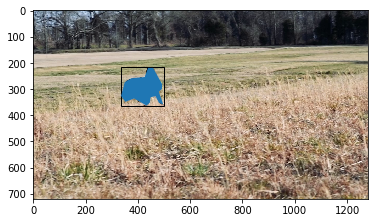

In [55]:
fig, ax = plt.subplots()

pos_dict = out_dict["bbox_dict"]
x1,y1,x2,y2 = pos_dict["x1"], pos_dict["y1"], pos_dict["x2"], pos_dict["y2"]

w = x2 - x1
h = y2 - y1

polygon_array = [[one_point["x"], one_point["y"]] for one_point in out_dict["polygon"]]

ax.imshow(image_array[1][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)
polygon = patches.Polygon(polygon_array, closed=True)
ax.add_patch(polygon)